# FKE pour le chemostat

On écrit le modèle du chemostat:
\begin{align*}
\dot X(t) &= f(X(t)) + \sigma \,\xi(t)\\
Y_k  &= h(X(t_k)) + V_k
\end{align*}
sous forme canonique en posant:
\begin{align*}
X=\begin{pmatrix} B\\ X\end{pmatrix}=\begin{pmatrix} x_1\\ x_2\end{pmatrix}
\end{align*}
On écrit $f$:
\begin{align*}
  f(X) = f(B,S) = \begin{pmatrix} 
    (\mu(S)-D)\,B \\ 
    D\,(S_{in}-S)-\kappa\,\mu(S)\,B
  \end{pmatrix}  = \begin{pmatrix} 
    (\mu(x_2)-D)\,x_1 \\ 
    D\,(S_{in}-x_2)-\kappa\,\mu(x_2)\,x_1
  \end{pmatrix}
\end{align*}
et son gradient:
\begin{align*}
  \nabla f(X) =
  \begin{pmatrix} 
    \mu(S)-D  &  \mu'(S)\,B \\ 
    -\kappa\,\mu(S) & D-\kappa\,\mu'(S)\,B  
  \end{pmatrix} = \begin{pmatrix} 
    \mu(x_2)-D  &  \mu'(x_2)\,x_1 \\ 
    -\kappa\,\mu(x_2) & D-\kappa\,\mu'(x_2)\,x_1  
  \end{pmatrix}
\end{align*}
De même $h$:
\begin{align*}
   h(X) = h(B,S) = \mu(S)\,B=\mu(x_2)\,x_1
\end{align*}
et son gradient:
\begin{align*}
   \nabla h(X) = \nabla h(B,S)  =  \begin{pmatrix}  \mu(S) &  \mu'(S)\,B  \end{pmatrix} = 
   \begin{pmatrix}  \mu(x_2) &  \mu'(x_2)\,x_1  \end{pmatrix}
\end{align*}
où
\begin{align*}
   \mu(S) =   \mu_{max}\,\frac{S}{K+S} 
\end{align*}
et
\begin{align*}
   \mu'(S) =   \mu_{max}\,\frac{(K+S)\,S'-(K+S)'\,S}{(K+S)^2} =   \mu_{max}\,\frac{K}{(K+S)^2}
\end{align*}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

x1, x2, p11, p12, p21, p22 = 1,2,3,0.1,0.1,5
vecteur = np.array([x1, x2, p11, p12, p21, p22])
state = vecteur[2:7].reshape((2, 2))
cov = vecteur[0:2].reshape((2, 1))
type(cov)
a = np.array([1.8 , 0.15])
b = np.array([1.8 , 0.15]).reshape((2, 1))

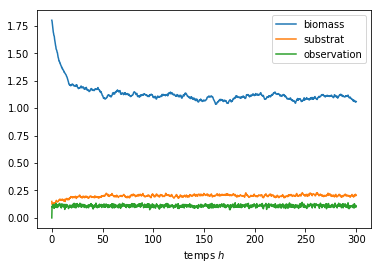

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


smin, smax = 0, 3 
bmin, bmax = 0, 1.5
ka = 2;         # stoichiometric coefficient
s_in = 2.4;     # input substrate concentration
D = 0.1;        # dillution rate
mu_max = 5;     # maximim of the specific rate (Monod case)
k_s      = 10;  # half saturation coeficient   (Monod case)
T = 300

Sigma = np.array([1, 0, 0, 1]).reshape((2, 2))
Qxi = np.array([0.0001, 0, 0, 0.0001]).reshape((2, 2))

Qv = 0.0001

EX0 = np.array([1.8 , 0.15]).reshape((2, 1))
VX0 = np.array([1, 0, 0, 1]).reshape((2, 2))

def f(x, t):
    "second memnbre de l'EDO chemostat"
    mu = mu_max*x[1]/(k_s+x[1])
    f1 = (mu-D)*x[0]
    f2 = D*(s_in-x[1])-ka*mu*x[0]
    return f1,f2

def Df(x):
    "differentielle second memnbre de l'EDO chemostat"
    mu = mu_max*x[1]/(k_s+x[1])
    D1f1 = mu-D
    D2f1 = mup*x[0]
    D1f2 = -ka*mu
    D3f2 = D-ka*mup*x[0]
    return D1f1,D2f1,D1f2,D3f2

def h(x):
    "fonction observation"
    mu = mu_max*x[1]/(k_s+x[1])
    h = mu*x[0]
    return h

def Dh(x):
    "differentielle fonction observation"
    mu = mu_max*x[1]/(k_s+x[1])
    mup = mu_max*1/(k_s+x[1])**2
    h = mu*x[0]
    return mu,mup*x[1]


def f_etendu(x_etendu, t):
    '''second membre étendu : 
    EDO chemostat couplé à l'EDO de Riccati pour FKE'''
    x = x_etendu[0:2].reshape((2,1))
    mu = mu_max*x[1]/(k_s+x[1])
    mup = mu_max*1/(k_s+x[1])**2
    f1 =(mu-D)*x[0]
    f2 = D*(s_in-x[1])-ka*mu*x[0]
    cov = x_etendu[2:7].reshape((2, 2))
    DF = np.array([mu-D, -ka*mu, mup*x[0], D-ka*mup*x[0]]).reshape((2, 2))
    Fcov = DF*cov+cov*DF.transpose()+Sigma*Qxi*Sigma.transpose()
    return [f1, f2, Fcov[0,0], Fcov[1,0], Fcov[0,1], Fcov[1,1]]


# SIMULATION

t_obs = np.linspace(0, T, 1201)  # pas d'observation en t_obs[0]=0 

X0 = EX0[0]  # biomasse initiale
S0 = EX0[1]  # subtrat initiale

X = np.ones_like(t_obs)
S = np.ones_like(t_obs)
Y = np.ones_like(t_obs)
X[0], S[0] = X0, S0
Y[0] = 0 # dummy value
i = 0
delta = t_obs[1]
i_max = len(t_obs)
for i in range(i_max-1):
    fX, fS = f([X[i],S[i]], 0)
    X[i+1] = X[i] + delta * fX + np.sqrt(Qxi[0,0]*delta)*np.random.randn()
    S[i+1] = S[i] + delta * fS + np.sqrt(Qxi[1,1]*delta)*np.random.randn()
    Y[i+1] = h([X[i+1],S[i+1]])  + np.sqrt(Qv)*np.random.randn()

plt.plot(t_obs,X,label='biomass')    
plt.plot(t_obs,S,label='substrat')    
plt.plot(t_obs,Y,label='observation')    
plt.xlabel(r'temps $h$')
plt.legend()
plt.show()


In [179]:
# FILTRAGE
R = np.ones((4,len(t_obs)))
hatX = np.ones((2,len(t_obs)))

hatX[:,0] = X0,S0
R[:,0] = 0,0,0,0

val_ini = np.concatenate([hatX[:,0] , R[:,0]])


np.shape(val_ini)


(6,)

In [217]:


for i in range(i_max-1):
    # prédiction
    val_ini = np.concatenate([hatX[:,0] , R[:,0]])
    tt,val_pred = odeint( f_etendu, val_ini, [t_obs[i],t_obs[i+1]])
    hatXpred = np.array(val_pred[0:2]).reshape((2, 1))
    Rpred = val_pred[2:6].reshape((2, 2))
    
  
    # correction
    H = np.array(Dh(hatXpred))
    gain = Rpred*H.transpose()/(H*Rpred*H.transpose()+Qv)
    hatXcor = hatXpred  + gain*(Y[i+1] - h(hatXpred))
    Rcor  = (np.identity(2)-gain*H)*Rpred

np.shape(np.array(H)*np.array(Rpred))                                 
       

(2, 2)

In [ ]:
    hatX[:,i+1] = hatXcor
    R[:,i+1] = Rcor

